In [1]:
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
import scipy.optimize as opt

# Module to load MATLAB .mat datafile format (Input and output module of scipy)
from scipy.io import loadmat

# Python Imaging Library (PIL)
from PIL import Image

# tells matplotlib to embed plots within the notebook
%matplotlib inline
from functools import partial

In [2]:
Data_Dir = 'DATA'
data = loadmat(os.path.join(Data_Dir, 'mnist-digit.mat'))

#### Regularized logistic regression

Now add regularization to the cost function. For regularized logistic regression, the cost function is defined as

$$ J(w) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)} \log \left(h_w\left(x^{(i)} \right)\right) - \left( 1 - y^{(i)} \right) \log\left(1 - h_w \left(x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n w_j^2 $$

Note that $w_0$ should not be regularized as it is used as bias term.
Correspondingly, the partial derivative of regularized logistic regression cost for $w_j$ is defined as

$$
\begin{align*}
& \frac{\partial J(w)}{\partial w_0} = \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}  & \text{for } j = 0 \\
& \frac{\partial J(w)}{\partial w_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_w\left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} w_j & \text{for } j  \ge 1
\end{align*}
$$


In [3]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    """
    return 1/(1+np.exp(-z))

In [4]:
X=data["X"]
w = np.zeros(X.shape[1])
print(w.shape)

print(X.shape)
y=data["y"]
y=y.squeeze()
print(y.shape)
h = sigmoid(X.dot(w))
print(h.shape)

(400,)
(5000, 400)
(5000,)
(5000,)


In [5]:
y = y.squeeze()
y = np.where(y==10,0,y)

In [6]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [7]:
X_final = np.hstack((np.ones((X.shape[0],1)),X))
lambda_ = 0.1

In [8]:
def lrCostFunction(w, X, y, lambda_,shape=False):
    
    m = y.size
    
    if y.dtype == bool:
        y = y.astype(int)

    h = sigmoid(np.dot(X,w))
    grad = np.zeros(w.shape)
    reg_term = (lambda_/(2*m))*np.sum(w[1:]**2)
    J = (1/m)*np.sum(-y*np.log(h+1e-10) - (1-y)*np.log(1-h+1e-10)) + reg_term
    grad[0] = (1/m)*np.dot((h-y),X[:,0])
    grad[1:]=(1/m)*(np.dot((h-y),X[:,1:])) + (lambda_/m) * w[1:]
    if shape:
        print('shape of grad: ', grad.shape)
        print('shape of J: ', J.shape)
        print('shape of h: ', h.shape)
        print('shape of w: ', w.shape)
        print('shape of X: ', X.shape)
        print('shape of y: ', y.shape)
    
    return J, grad

In [15]:
def partial_parabola(x, a):
    return a*x**2

In [16]:
parabola = partial(partial_parabola, a=2)

In [17]:
parabola(2)

8

In [9]:
w_final = np.zeros(X_final.shape[1])

In [18]:
def callback_partial(W, X, y, history,):
    J, _ = lrCostFunction(W, X, y, lambda_)
    history.append(J)

In [14]:
from functools import partial

In [19]:

def oneVsAll(X, y, num_labels, lambda_):
        
    m, n = X.shape  
    
    all_w = np.zeros((num_labels, n ))
    all_j = []
    w = np.zeros(n)

    for c in np.arange(num_labels):
        J_history = []
        print(f"Currently Training for {c}", end="\r")
        y_c = np.where(y==c,1,0)        
        callbackF = partial(callback_partial, X=X, y=y_c, history=J_history)
        res = opt.minimize(lrCostFunction, w, args=(X,y_c,lambda_), method='CG', jac=True,callback=callbackF, options={'maxiter': 100}, tol=1e-6)
        all_w[c] = res.x
        # print(res)
        all_j.append(J_history)
        # print('class: ', c, 'cost: ', res.fun)

    return all_w, all_j

In [20]:
all_w, all_j=oneVsAll(X_final, y, 10, lambda_)

In [21]:
def pred(all_w, X):
    
    pred = np.argmax(sigmoid(X.dot(all_w.T)), axis=1)
    assert pred.shape == (X.shape[0],)
    return pred

In [22]:
y_pred = pred(all_w, X_final)

In [23]:
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [25]:
accuracy = np.mean(y_pred == y)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 96.14%


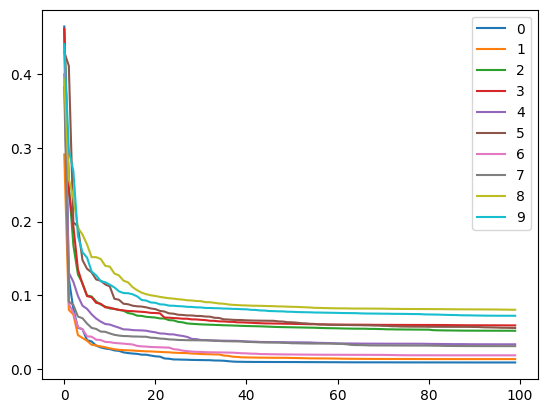

In [30]:
all_j = np.array(all_j)
for i in range(10):
    plt.plot(all_j[i], label=i)
plt.legend()
plt.show()